# **Packages needed**

In [124]:
import yfinance as yf
from datetime import datetime
import pandas as pd
import numpy as np
import ta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# **Data needed**

In [125]:
naf_df = pd.read_csv('naf_df.csv')

print(naf_df.head())


         Date   High    Low   Open  Close  Volume
0  06/03/2025  21.20  20.80  21.10  20.80  360200
1  05/03/2025  21.20  20.45  20.50  21.10  846800
2  04/03/2025  20.55  20.30  20.40  20.50  379200
3  03/03/2025  20.45  20.20  20.40  20.40  361400
4  28/02/2025  20.85  20.40  20.65  20.55  316800


In [126]:
# View basic information
print(naf_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1500 non-null   object 
 1   High    1500 non-null   float64
 2   Low     1500 non-null   float64
 3   Open    1500 non-null   float64
 4   Close   1500 non-null   float64
 5   Volume  1500 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 70.4+ KB
None


In [127]:
# Change all to datetimelike
naf_df['Date'] = pd.to_datetime(naf_df['Date'], dayfirst=True)

# View one of them to recheck
naf_df.head()

,Date,High,Low,Open,Close,Volume
0,2025-03-06,21.20,20.80,21.10,20.80,360200
1,2025-03-05,21.20,20.45,20.50,21.10,846800
2,2025-03-04,20.55,20.30,20.40,20.50,379200
3,2025-03-03,20.45,20.20,20.40,20.40,361400
4,2025-02-28,20.85,20.40,20.65,20.55,316800


In [128]:
# Reverse the datasets
naf_df = naf_df.iloc[::-1]

# View one of them to recheck
naf_df.head()

,Date,High,Low,Open,Close,Volume
1499,2019-03-06,15.5,15.15,15.3,15.5,80080
1498,2019-03-07,15.6,15.30,15.5,15.6,157010
1497,2019-03-08,15.5,15.20,15.5,15.2,103080
1496,2019-03-11,15.5,15.20,15.2,15.5,59060
1495,2019-03-12,15.5,15.20,15.5,15.2,71310


## **Technical indicators**

In [129]:
# Calculate simple moving average
naf_df['SMA_200'] = naf_df['Close'].rolling(window = 200).mean()

# Drop all empty rows
naf_df.dropna(inplace = True)

# View one to check
naf_df.head()

,Date,High,Low,Open,Close,Volume,SMA_200
1300,2019-12-17,25.0,24.5,24.80,24.60,143760,19.14250
1299,2019-12-18,24.7,24.2,24.55,24.40,65890,19.18700
1298,2019-12-19,24.8,24.2,24.20,24.70,93800,19.23250
1297,2019-12-20,26.4,24.5,24.60,26.35,500150,19.28825
1296,2019-12-23,26.5,26.2,26.50,26.50,234170,19.34325


In [130]:
# Calculate RSI
naf_df['RSI'] = ta.momentum.RSIIndicator(naf_df['Close'].squeeze(), window = 14).rsi()

# View one to check
naf_df.head()

,Date,High,Low,Open,Close,Volume,SMA_200,RSI
1300,2019-12-17,25.0,24.5,24.80,24.60,143760,19.14250,NaN
1299,2019-12-18,24.7,24.2,24.55,24.40,65890,19.18700,NaN
1298,2019-12-19,24.8,24.2,24.20,24.70,93800,19.23250,NaN
1297,2019-12-20,26.4,24.5,24.60,26.35,500150,19.28825,NaN
1296,2019-12-23,26.5,26.2,26.50,26.50,234170,19.34325,NaN


In [131]:
# Calculate stochastic oscillator
naf_df['STOCH'] = ta.momentum.StochasticOscillator(high = naf_df['High'], low = naf_df['Low'], close = naf_df['Close'], window = 14).stoch()

# View one to see
naf_df.head()

,Date,High,Low,Open,Close,Volume,SMA_200,RSI,STOCH
1300,2019-12-17,25.0,24.5,24.80,24.60,143760,19.14250,NaN,NaN
1299,2019-12-18,24.7,24.2,24.55,24.40,65890,19.18700,NaN,NaN
1298,2019-12-19,24.8,24.2,24.20,24.70,93800,19.23250,NaN,NaN
1297,2019-12-20,26.4,24.5,24.60,26.35,500150,19.28825,NaN,NaN
1296,2019-12-23,26.5,26.2,26.50,26.50,234170,19.34325,NaN,NaN


In [132]:
# Drop all null columns
naf_df.dropna(inplace = True)

# Filter to get only from 2020-01-22 to 2025-01-14
naf_df = naf_df[(naf_df['Date'] >= '2020-01-22') & (naf_df['Date'] <= '2025-01-14')]

# And set date to be index
naf_df.set_index('Date', inplace = True)

# View one to check
naf_df.head()

,High,Low,Open,Close,Volume,SMA_200,RSI,STOCH
Date,,,,,,,,
2020-01-22,26.0,25.50,25.90,25.90,8950,20.44650,54.395163,36.363636
2020-01-30,26.2,24.70,25.90,25.80,11370,20.49950,52.389381,42.307692
2020-01-31,25.7,24.50,25.70,25.50,7800,20.55125,46.812501,35.714286
2020-02-03,25.2,23.75,24.45,24.45,137960,20.59800,33.407987,19.718310
2020-02-04,24.0,23.60,24.00,23.80,5390,20.64150,28.052805,5.405405


# **Add more data**

In [133]:
# Add GDP data in
gdp = pd.read_csv('gdp.csv', parse_dates=["Quarter"])
gdp

,Quarter,%Growth
0,Q1 2020,3.21
1,Q2 2020,0.39
2,Q3 2020,2.69
3,Q4 2020,4.48
4,Q1 2021,4.72
5,Q2 2021,6.73
6,Q3 2021,-6.02
7,Q4 2021,5.22
8,Q1 2022,5.05
9,Q2 2022,7.99


In [134]:
# Convert quarter of GDP dataset back to datetimelike
gdp['Quarter'] = gdp['Quarter'].astype(str)
gdp['Quarter'] = gdp['Quarter'].str.replace('Q1', '-01-01', regex=True)\
                                .str.replace('Q2', '-04-01', regex=True)\
                                .str.replace('Q3', '-07-01', regex=True)\
                                .str.replace('Q4', '-10-01', regex=True)

In [135]:
gdp['Quarter'] = pd.to_datetime(gdp['Quarter'], errors='coerce')
gdp

,Quarter,%Growth
0,2020-01-01,3.21
1,2020-04-01,0.39
2,2020-07-01,2.69
3,2020-10-01,4.48
4,2021-01-01,4.72
5,2021-04-01,6.73
6,2021-07-01,-6.02
7,2021-10-01,5.22
8,2022-01-01,5.05
9,2022-04-01,7.99


In [136]:
# Convert quarterly % growth to decimal
gdp['%Growth'] = gdp['%Growth'] / 100

# Create a full daily date range
daily_dates = pd.date_range(start = naf_df.index.min(), end = naf_df.index.max(), freq = 'D')
gdp_daily = pd.DataFrame({'Date': daily_dates})

# Merge and forward-fill quarterly growth rates
gdp_daily = gdp_daily.merge(gdp, left_on = 'Date', right_on = 'Quarter', how = 'left')
gdp_daily['%Growth'] = gdp_daily['%Growth'].bfill().ffill()

# Calculate daily growth rate assuming continuous compounding
gdp_daily['Daily growth'] = np.log(1 + gdp_daily['%Growth']) / 90

# Apply cumulative growth from a base value
gdp_daily['GDP_Index'] = 100 * np.exp(gdp_daily['Daily growth'].cumsum())

gdp_daily

,Date,Quarter,%Growth,Daily growth,GDP_Index
0,2020-01-22,NaT,0.0039,0.000043,100.004325
1,2020-01-23,NaT,0.0039,0.000043,100.008650
2,2020-01-24,NaT,0.0039,0.000043,100.012976
3,2020-01-25,NaT,0.0039,0.000043,100.017301
4,2020-01-26,NaT,0.0039,0.000043,100.021627
...,...,...,...,...,...
1815,2025-01-10,NaT,0.0755,0.000809,284.930202
1816,2025-01-11,NaT,0.0755,0.000809,285.160727
1817,2025-01-12,NaT,0.0755,0.000809,285.391438
1818,2025-01-13,NaT,0.0755,0.000809,285.622336


In [137]:
# We use GDP index
gdp_daily = gdp_daily[['Date', 'GDP_Index']]
gdp_daily.set_index('Date', inplace = True)

# Merge this with 6 datasets
naf_df = naf_df.merge(gdp_daily, left_index = True, right_index = True)

# View one to check
naf_df.head()

,High,Low,Open,Close,Volume,SMA_200,RSI,STOCH,GDP_Index
Date,,,,,,,,,
2020-01-22,26.0,25.50,25.90,25.90,8950,20.44650,54.395163,36.363636,100.004325
2020-01-30,26.2,24.70,25.90,25.80,11370,20.49950,52.389381,42.307692,100.038932
2020-01-31,25.7,24.50,25.70,25.50,7800,20.55125,46.812501,35.714286,100.043258
2020-02-03,25.2,23.75,24.45,24.45,137960,20.59800,33.407987,19.718310,100.056240
2020-02-04,24.0,23.60,24.00,23.80,5390,20.64150,28.052805,5.405405,100.060567


## **Interest rates**

In [138]:
ir = pd.read_excel('ir.xlsx')
ir.head()

,Date,%
0,2020-01-31,6.0
1,2020-02-29,6.0
2,2020-03-17,5.0
3,2020-04-30,5.0
4,2020-05-12,4.5


In [139]:
ir['Date'] = pd.to_datetime(ir['Date'])
ir.rename(columns={"%": "Interest rates"}, inplace=True)
# Create a full daily date range from min to max date
daily_dates = pd.date_range(start=naf_df.index.min(), end=naf_df.index.max(), freq="D")
daily_ir = pd.DataFrame({"Date": daily_dates})

# Merge and forward-fill quarterly growth rates
daily_ir = daily_ir.merge(ir, on = 'Date', how="left")

# Calculate daily growth rate assuming continuous compounding
daily_ir['Interest rates'] = daily_ir['Interest rates'].interpolate(method = 'linear')
daily_ir['Interest rates'] = daily_ir['Interest rates'].fillna(method = 'bfill')

daily_ir

,Date,Interest rates
0,2020-01-22,6.0
1,2020-01-23,6.0
2,2020-01-24,6.0
3,2020-01-25,6.0
4,2020-01-26,6.0
...,...,...
1815,2025-01-10,4.5
1816,2025-01-11,4.5
1817,2025-01-12,4.5
1818,2025-01-13,4.5


In [140]:
# Merge with 6 datasets
daily_ir.set_index('Date', inplace = True)

naf_df = naf_df.merge(daily_ir, left_index = True, right_index = True)

# View one to see
naf_df.head()

,High,Low,Open,Close,Volume,SMA_200,RSI,STOCH,GDP_Index,Interest rates
Date,,,,,,,,,,
2020-01-22,26.0,25.50,25.90,25.90,8950,20.44650,54.395163,36.363636,100.004325,6.0
2020-01-30,26.2,24.70,25.90,25.80,11370,20.49950,52.389381,42.307692,100.038932,6.0
2020-01-31,25.7,24.50,25.70,25.50,7800,20.55125,46.812501,35.714286,100.043258,6.0
2020-02-03,25.2,23.75,24.45,24.45,137960,20.59800,33.407987,19.718310,100.056240,6.0
2020-02-04,24.0,23.60,24.00,23.80,5390,20.64150,28.052805,5.405405,100.060567,6.0


In [141]:
# Drop unnecessary columns
naf_df.drop(['High', 'Low', 'Open', 'Volume'], axis = 1, inplace = True)

naf_df.head()

,Close,SMA_200,RSI,STOCH,GDP_Index,Interest rates
Date,,,,,,
2020-01-22,25.90,20.44650,54.395163,36.363636,100.004325,6.0
2020-01-30,25.80,20.49950,52.389381,42.307692,100.038932,6.0
2020-01-31,25.50,20.55125,46.812501,35.714286,100.043258,6.0
2020-02-03,24.45,20.59800,33.407987,19.718310,100.056240,6.0
2020-02-04,23.80,20.64150,28.052805,5.405405,100.060567,6.0


# **ARIMAX models**

In [142]:
# Define evaluation metrics
def calculate_accuracy(real, predict):
    return (1 - np.sqrt(np.mean(np.square((real - predict) / real)))) * 100

def evaluate_performance(real, predict):
    mse = mean_squared_error(real, predict)
    rmse = np.sqrt(mse)
    accuracy = calculate_accuracy(real, predict)
    return mse, rmse, accuracy

In [143]:
# Split data into train and test (80:20)
train_size = int(len(naf_df) * 0.8)
train, test = naf_df.iloc[:train_size], naf_df.iloc[train_size:]

# Define target variable and exogenous features
y_train, y_test = train['Close'], test['Close']
exog_train = train[['SMA_200', 'RSI', 'STOCH', 'GDP_Index', 'Interest rates']]
exog_test = test[['SMA_200', 'RSI', 'STOCH', 'GDP_Index', 'Interest rates']]

In [144]:
# Use auto_arima to find the best (p, d, q) order
auto_arima_model = auto_arima(y_train, exogenous=exog_train, seasonal=False, stepwise=True, suppress_warnings=True)
best_order = auto_arima_model.order
print(f"Best ARIMA Order: {best_order}")
print(auto_arima_model.summary())

Best ARIMA Order: (0, 1, 1)
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  996
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -595.403
Date:                Fri, 07 Mar 2025   AIC                           1194.806
Time:                        02:01:19   BIC                           1204.611
Sample:                             0   HQIC                          1198.533
                                - 996                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1540      0.023      6.692      0.000       0.109       0.199
sigma2         0.1938      0.006     33.481      0.000       0.182       0.205
Ljung-Box (L1) (Q):     

In [145]:
# Fit SARIMAX model using the best order
sarimax_model = SARIMAX(y_train, exog=exog_train, order=best_order, enforce_stationarity=False, enforce_invertibility=False)
sarimax_result = sarimax_model.fit(disp=False)
# Print model summary
print(sarimax_result.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  996
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 160.461
Date:                Fri, 07 Mar 2025   AIC                           -306.922
Time:                        02:01:20   BIC                           -272.617
Sample:                             0   HQIC                          -293.879
                                - 996                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
SMA_200            0.6598      0.221      2.989      0.003       0.227       1.092
RSI                0.0806      0.002     50.349      0.000       0.077       0.084
STOCH              0.0005      0.001

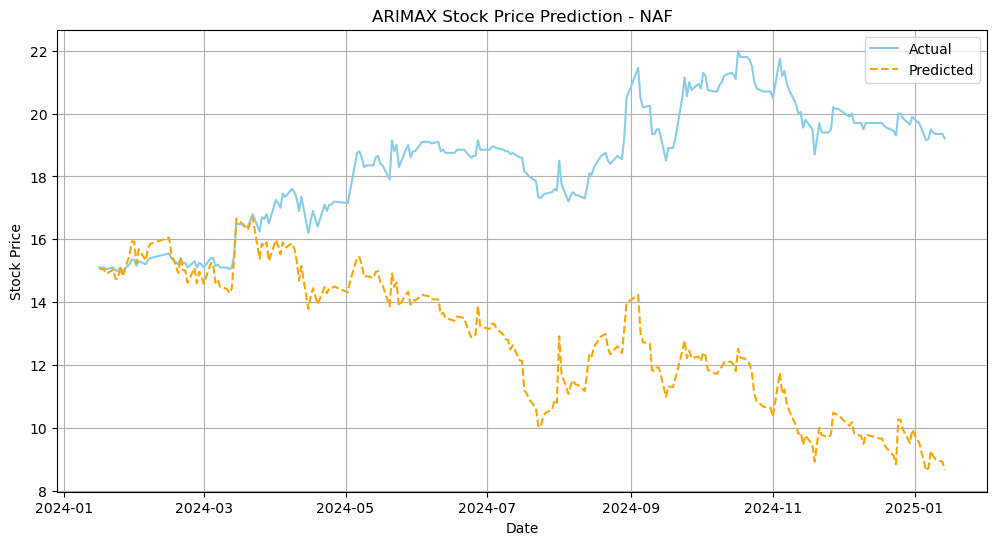

In [146]:
# Make predictions on the test set
predictions = sarimax_result.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=exog_test)

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, label="Actual", color="skyblue")
plt.plot(test.index, predictions, label="Predicted", color="orange", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("ARIMAX Stock Price Prediction - NAF")
plt.legend()
plt.grid()
plt.show()

In [147]:
predictions.index = y_test.index  # Assign y_test's index to predictions

In [148]:
# Evaluate performance
mse, rmse, accuracy = evaluate_performance(y_test, predictions)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"Accuracy: {accuracy:.2f}%")

MSE: 44.98
RMSE: 6.71
Accuracy: 65.81%
